# Repairing geographic locations, place names, and extracted data for the NWT Climate Explorer.

## Issue
The location of Inuvik, NWT was found to be incorrect by about ten degrees of longitude. A closer examination of all point locations used by the web tool found that many of the geographic coordinates were in need of refinement and that some place names needed to be updated.

## Fix
A revised spreadsheet of NWT geographic locations was produced (see https://github.com/ua-snap/geospatial-vector-veracity/blob/main/vector_data/point/nwt_point_locations.csv) and used to re-extract downscaled data for each location.

## Validation
This notebook will compare the existing data to the newly extracted data and check for data model integrity and for qualitative similarity.

### Usage note
This notebook switches branches so it should probably be used outside the repo itself. Just `cd` in to the repo.

In [1]:
pwd

'/Users/cparr/workspace/tmp'

In [2]:
cd '../repos/nwt-dash-app/data_prep'

/Users/cparr/workspace/repos/nwt-dash-app/data_prep


In [3]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from glob import glob

The previously extracted CSV files (incorrect for Inuvik) are still on branch `master` while the freshly extracted data is on branch `inuvik-rextraction` (forgive the missing 'e'). I want to pull both sets of CSV files and compare them. I'll use the `subprocess` module to checkout the different git branches. This is probably not advisable and should only be used if both branches have clean working trees (no changes, nothing staged, etc.). Using git in the notebook is confusing (but fun!) because it is sensitive to the state of the git repository as it was left in the terminal. Only two branches are relevant here so I can be agnostic regarding which branch this "starts" on. This technique will also hang up if this notebook is being tracked in git because it will see the modifications and yell at you about performing a `checkout`. The recommendation is to use the notebook outside the repo and then chuck it back in when you are ready to commit.

In [4]:
di_branches = defaultdict()
di_branches['master'] = 'inuvik-rextraction'
di_branches['inuvik-rextraction'] = 'master'

def which_branch():
    proc_branch = subprocess.Popen(["git", "branch"], stdout=subprocess.PIPE, universal_newlines=True)
    out_branch = proc_branch.communicate()[0].splitlines()
    current_branch = [x for x in out_branch if x[0] == '*'][0].split(' ')[-1]
    return current_branch

def switch_branch(di_branches):
    checkout = subprocess.Popen(["git", "checkout", di_branches[which_branch()]],
                                stdout=subprocess.PIPE,
                                universal_newlines=True)

In [5]:
which_branch()

'master'

In [6]:
scenarios = ['historical', 'rcp45', 'rcp60', 'rcp85']

di_csv = defaultdict()

def qa_prep():
    di_csv[which_branch()] = {}
    for sc in scenarios:
        di_csv[which_branch()][sc] = {}
        df = pd.read_csv(glob('../data/*' + sc + '*.csv')[0])
        di_csv[which_branch()][sc]['csv'] = df
        di_csv[which_branch()][sc]['shape'] = df.shape
        di_csv[which_branch()][sc]['models'] = sorted(list(df.model.unique()))
        di_csv[which_branch()][sc]['years'] = sorted(list(df.model.unique()))
        di_csv[which_branch()][sc]['place_names'] = sorted(list(df.community.unique()))

qa_prep()

In [7]:
switch_branch(di_branches)

In [8]:
which_branch()

'inuvik-rextraction'

In [9]:
qa_prep()

A dictionary is now populated with the old and new CSV files. Both sets of data are extracted from the same source, so the expectation is that the models and time ranges did not change across extractions. Each scenario is contained within a single CSV file (only 8 CSVs total) so a quick check of the models and years between each scenario pair will suffice.

In [10]:
for sc in scenarios:
    model_check = di_csv['master'][sc]['models'] == di_csv['inuvik-rextraction'][sc]['models']  
    yr_check = di_csv['master'][sc]['years'] == di_csv['inuvik-rextraction'][sc]['years']
    print("Checking %s... Models identical? %s. Years Identical? %s." % (sc, model_check, yr_check))

Checking historical... Models identical? True. Years Identical? True.
Checking rcp45... Models identical? True. Years Identical? True.
Checking rcp60... Models identical? True. Years Identical? True.
Checking rcp85... Models identical? True. Years Identical? True.


However, changes to the place names themselves and the number of extracted locations were made. Specfically, the number of communities was reduced by one in new data extraction because Behchokǫ̀ was previously represented by separate extractions for Behchoko (Rae) and  Behchoko (Edzo). Rae and Edzo were distinct communities, though only located only a few kilometers apart, but are now unified under the name Behchokǫ̀.

The point is that we will have different data shapes and sizes (and obviously different community names) between the two sets of data.

In [11]:
old_places_not_in_new = []
new_places_not_in_old = []

for sc in scenarios:
    
    old_places = di_csv['master'][sc]['place_names']
    new_places = di_csv['inuvik-rextraction'][sc]['place_names']
    old_locs_not_in_new = list(set(old_places) - set(new_places))
    new_locs_not_in_old = list(set(new_places) - set(old_places))

    old_places_not_in_new.append(sorted(old_locs_not_in_new))
    new_places_not_in_old.append(sorted(new_locs_not_in_old))

print("Dropped Location Names")
print(np.unique(old_places_not_in_new))
print('-----------------------------')
print("Added Location Names")
print(np.unique(new_places_not_in_old))

print("Number Old places: %d" % len(old_places))
print("Number New places: %d" % len(new_places))

Dropped Location Names
['Behchoko (Edzo)' 'Behchoko (Rae)' 'Daring Lake Research Stn' 'Detah'
 'Gameti' "Lutselk'e" "N'Dilo" 'Nechalacho' 'Pine Point Mine (Tamerlane)'
 'Trout Lake' 'Wekweeti' 'Whati']
-----------------------------
Added Location Names
['Behchokǫ̀' 'Daring Lake Research Station' 'Dettah' 'Gamètì' 'Ndilǫ'
 'Nechalacho/Thor Lake' 'Pine Point Mine' 'Sambaa K’e' 'Wekweètì' 'Whatì'
 'Łutselkʼe']
Number Old places: 47
Number New places: 46


A reduction in the number of communities by one will reduce the size of each DataFrame by the amount of rows per community for that scenario. We can do quick check on this as well.

In [12]:
for sc in scenarios:
    print(sc)
    old_shape = di_csv['master'][sc]['shape']
    new_shape = di_csv['inuvik-rextraction'][sc]['shape']
    row_delta = old_shape[0] - new_shape[0]
    print("Old CSV Shape:", old_shape)
    print("New CSV Shape:", new_shape)
    print("Old - New Shape Difference (Number Rows):", row_delta)
    rows_per_location = di_csv['master'][sc]['csv'].query("community == 'Inuvik'").shape[0]
    print("Shape Difference Accounted for by reduction of point locations by one:", row_delta == rows_per_location)


historical
Old CSV Shape: (49632, 8)
New CSV Shape: (48576, 8)
Old - New Shape Difference (Number Rows): 1056
Shape Difference Accounted for by reduction of point locations by one: True
rcp45
Old CSV Shape: (75576, 8)
New CSV Shape: (73968, 8)
Old - New Shape Difference (Number Rows): 1608
Shape Difference Accounted for by reduction of point locations by one: True
rcp60
Old CSV Shape: (41736, 8)
New CSV Shape: (40848, 8)
Old - New Shape Difference (Number Rows): 888
Shape Difference Accounted for by reduction of point locations by one: True
rcp85
Old CSV Shape: (64296, 8)
New CSV Shape: (62928, 8)
Old - New Shape Difference (Number Rows): 1368
Shape Difference Accounted for by reduction of point locations by one: True


I am satisfied that the data is essentially intact between the two extractions. The same time ranges, models, and scenarios are all accounted for. The changes in the communities are expected. Now I'll do a brief qualitative examination to look at Inuvik because it was known to be incorrect. Other examinations like this are probably better left to the app itself.

Text(0, 0.5, 'temp (RCP 8.5)')

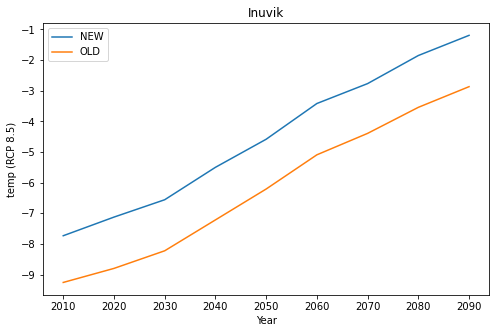

In [13]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")
new_inuvik = di_csv['inuvik-rextraction']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")

plt.plot(new_inuvik[['year', 'tas']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'tas']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Inuvik')
plt.xlabel('Year')
plt.ylabel('temp (RCP 8.5)')

Text(0, 0.5, 'precip (RCP 8.5)')

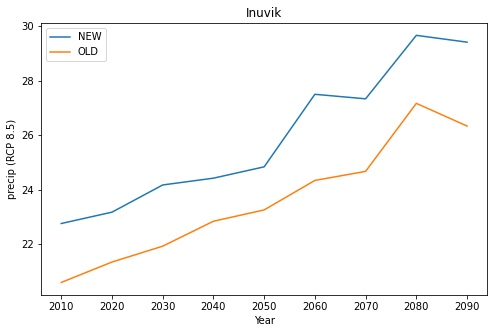

In [14]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")
new_inuvik = di_csv['inuvik-rextraction']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")

plt.plot(new_inuvik[['year', 'pr']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'pr']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Inuvik')
plt.xlabel('Year')
plt.ylabel('precip (RCP 8.5)')